# Let's see if it's working

In [28]:
import torch

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *

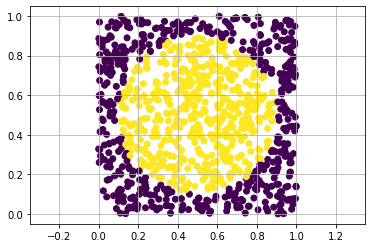

In [29]:
# Create test data
x = torch.rand((1000, 2))
pi = torch.acos(torch.zeros(1)).item() * 2
target = ((x - torch.Tensor([0.5, 0.5])).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

# Plot test data
plt.scatter(x.numpy()[:,0], x.numpy()[:,1], c=target)
plt.axis('equal')
plt.grid()
plt.show()

In [31]:
# Define network
LinNet = Sequential((
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)),
    MSELoss()
)

In [35]:
# Iterate over samples in x
for i in range(len(x)):
    # Get one data sample
    x_sample = x[i]

    # Forward
    out = LinNet(x_sample)

    # Backward
    LinNet.backward()

    # Update params
    LinNet(optim='sgd', lr=0.01)

TypeError: backward() missing 2 required positional arguments: 'x' and 'y'